In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go
from utils import parse_real_disp, CABC_Displacement, CABC_Force, parse_real_force

torch.set_default_dtype(torch.float64)

# Random Parameter Generation

In [ ]:
# Bounds
# n_bounds = (0.0, 1.0)
# tau_star_bounds = (1.0, 1000.0)
# B_bounds_log = (np.log10(1.0e+14), np.log10(1.916e+19))  # log10 scaling
# tau_w_bounds = (0.001, 1.0)
# m_bounds = (0.1, 1.9)

# LHs Sampling
# sampler = qmc.LatinHypercube(d=5)
# sample = sampler.random(15)  # 5 samples

# # Scaling
# n_values = sample[:, 0] * (n_bounds[1] - n_bounds[0]) + n_bounds[0]
# tau_star_values = sample[:, 1] * (tau_star_bounds[1] - tau_star_bounds[0]) + tau_star_bounds[0]
# B_values = 10 ** (sample[:, 2] * (B_bounds_log[1] - B_bounds_log[0]) + B_bounds_log[0])
# tau_w_values = sample[:, 3] * (tau_w_bounds[1] - tau_w_bounds[0]) + tau_w_bounds[0]
# m_values = sample[:, 4] * (m_bounds[1] - m_bounds[0]) + m_bounds[0]

# # save2CSV
# df = pd.DataFrame({
#     'n': n_values,
#     'tau_star': tau_star_values,
#     'B': B_values,
#     'tau_w': tau_w_values,
#     'm': m_values
# })
# df.to_csv("combined_LHS_parameters.csv", index=False)

# XML Parsing - Master Curve

In [2]:
# Directories
real_disp_path = "H:\\Real_data\\press_displacement_real.xml"
real_force_path = "H:\\Real_data\\press_force_real.xml"

# Displacement XML

# real_disp_time, real_disp = parse_real_disp(real_disp_path)

# real_tree = ET.parse(real_disp_path)
# real_root = real_tree.getroot()
# real_data = []
# guess_data_all = {}

# for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):

#     time_value = time_block.attrib.get('Value')
#     dept_value = dept_block.find('DeptValues').text.strip()
#     real_data.append((time_value, dept_value))

# real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
# real_time = real_data_array[:, 0]  
# real_disp = real_data_array[:, 1] * 0.0001019716


# Force XML

# real_force_time, real_force = parse_real_force(real_force_path)

def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_disp_resampled = np.interp(common_time, real_time, real_disp)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)
    
    return mse

real_data_directory = "H:\\Real_data\\press_force_real.xml"
areas = []
area_data = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data_all = {}

count = 0

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    if count >=  27:
        break  # Stop the loop after collecting 27 values

    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

    count += 1

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1] * 0.0001019716

In [3]:
df = pd.read_csv('combined_LHS_parameters.csv')

n_values = df['n'].tolist()
tau_star_values = df['tau_star'].tolist()
B_values = df['B'].tolist()
tau_w_values = df['tau_w'].tolist()
m_values = df['m'].tolist()

# Moldflow Simulation

In [ ]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2026\\bin"                        #Home D:\\Moldflow Insight 2023\\bin       #WS "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"  #"G:\\Oskay Sözen\\wall_slip\\wall slip.mpi"


Synergy.OpenProject("G:\\Oskay Sözen\\viscosity\\viscosity.mpi")
Project = Synergy.Project
Project.OpenItemByName("50SurfaceCoverage_study", "Study")



#Simulation loop for wall slip parameters
# for i in range(15):

#     n = n_values[i]
#     tau_star = tau_star_values[i]
#     B = B_values[i]
#     tau_w = tau_w_values[i]
#     m = m_values[i]


#     print(f"Simulation {i+1} with \nn : {n}\ntau_star : {tau_star}\nB : {B}\ntau_w : {tau_w}\nm : {m}")

#     study_name = f"study_{i+1}"
#     Project = Synergy.Project

#     # Viscosity Parameters

#     PropEd = Synergy.PropertyEditor
#     Prop = PropEd.FindProperty(10090,1)
#     Prop.FieldDescription(53030, f"{n}, {tau_star}, {B}, 0.004, 2.412, 6.272, 0.305")
#     PropEd.CommitChanges("Process Conditions")

#     # Wall Slip Parameters

#     PropEd = Synergy.PropertyEditor
#     Prop = PropEd.FindProperty(10090, 1)
#     DVec = Synergy.CreateDoubleArray
    
#     DVec.AddDouble(tau_w)
#     DVec.AddDouble(m)
#     DVec.AddDouble(1e-08)
#     DVec.AddDouble(0)
#     DVec.AddDouble(0)
    
#     Prop.FieldValues(51182, DVec)
        
#     PropEd.CommitChanges("Process Conditions")

#     StudyDoc = Synergy.StudyDoc
#     StudyDoc.SaveAs(study_name)

#     p = subprocess.Popen(
#     [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\viscosity\\study_{i+1}.sdy"],
#     stdout=subprocess.PIPE,
#     stderr=subprocess.STDOUT,
#     )
#     (output, err) = p.communicate()

#     time.sleep(3)

#     # Restart of the Synergy to prevent XML saving crash
    
#     subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

#     time.sleep(3)

#     Synergy.OpenProject("G:\\Oskay Sözen\\viscosity\\viscosity.mpi")         # PROJECT NAME!!!!!!!!!!!!!!!!
#     Project = Synergy.Project
#     Project.OpenItemByName(f"study_{i+1}", "Study")

#     # Plot Export

#     PlotMgr = Synergy.PlotManager
#     time.sleep(3)
#     Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
#     Pid = Plot.GetDataID
#     PlotMgr = None
#     PlotMgr = Synergy.PlotManager
#     time.sleep(3)
#     PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_{i + 1}_force.xml", "Metric")

#     PlotMgr = Synergy.PlotManager
#     time.sleep(3)
#     Plot = PlotMgr.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
#     Pid = Plot.GetDataID
#     PlotMgr = None
#     PlotMgr = Synergy.PlotManager
#     time.sleep(3)
#     PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_{i + 1}_disp.xml", "Metric")


# # Write the output to a log file
#     with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
#         file.write(output.decode("windows-1252").strip())



# XML Parsing - Guess Curves

In [4]:
guess_disp_data_all = {}
guess_force_data_all = {}
area_data = []
guess_data_all = {}

#Displacement XML

# for i in range(5):
#     guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}_disp.xml")
#     guess_root = guess_tree.getroot()
#     guess_data = []

#     for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
#             time_value = time_block.attrib.get('Value')
#             dept_value = dept_block.find('DeptValues').text.strip()
#             guess_data.append((time_value, dept_value))

#     guess_disp_data_all[f"guess_data_{i+1}"] = guess_data

#     guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
#     guess_disp_time = guess_data_array[:, 0]  
#     guess_disp = guess_data_array[:, 1]

#     globals()[f"guess_disp_time_{i+1}"] = guess_disp_time
#     globals()[f"guess_disp_{i+1}"] = guess_disp

#     mse_disp = CABC_Displacement(real_disp_time, real_disp, guess_disp_time, guess_disp)
#     area_data.append(mse_disp)

# print(guess_disp_data_all)

# Force XML
# for i in range(5):
#     guess_tree = ET.parse(f"H:\\XMLFiles\\study{i + 1}_force.xml")
#     guess_root = guess_tree.getroot()
#     guess_data = []

#     for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
#         if len(guess_data) >= 15:
#             break
        
#         time_value = time_block.attrib.get('Value')
#         dept_value = dept_block.find('DeptValues').text.strip()
#         guess_data.append((time_value, dept_value))


#     guess_force_data_all[f"guess_data_{i+1}"] = guess_data

#     guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
#     guess_force_time = guess_data_array[:, 0]  
#     guess_force = guess_data_array[:, 1]

#     globals()[f"guess_force_time_{i+1}"] = guess_force_time
#     globals()[f"guess_force_{i+1}"] = guess_force

#     mse_force = CABC_Force(real_force_time, real_force, guess_force_time, guess_force)
#     area_data.append(mse_force)

# print(guess_force_data_all)

valid_xml = []
for i in range(15):
        guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}_force.xml")
        guess_root = guess_tree.getroot()
        guess_data = []

        count = 0
                
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
                if count >= 35:
                        break


                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                guess_data.append((time_value, dept_value))

                count += 1
        if len(guess_data) < 27:
                print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
                continue

        guess_data_all[f"guess_data_{i+1}"] = guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1]

        globals()[f"guess_time_{i+1}"] = guess_time
        globals()[f"guess_disp_{i+1}"] = guess_disp


        mean_s_error = CABC_Force(real_time, real_disp, guess_time, guess_disp)
        area_data.append(mean_s_error)
        valid_xml.append(len(area_data) - 1)

        
print(guess_data_all)

{'guess_data_1': [('0.002000', '1.4992e+01'), ('0.018388', '2.0251e+01'), ('0.104796', '2.5151e+01'), ('0.176555', '1.4345e+02'), ('0.255645', '1.4989e+02'), ('0.355739', '1.2899e+02'), ('0.420182', '1.3231e+02'), ('0.501788', '1.1276e+02'), ('0.555425', '1.0015e+02'), ('0.593199', '8.2466e+01'), ('0.624635', '7.5447e+01'), ('0.646806', '8.1914e+01'), ('0.665582', '9.2174e+01'), ('0.687036', '7.9831e+01'), ('0.703032', '9.3970e+01'), ('0.715349', '1.3729e+02'), ('0.723156', '1.4985e+02'), ('0.732788', '1.5002e+02'), ('0.743104', '1.5052e+02'), ('0.754851', '1.5047e+02'), ('0.767356', '1.5023e+02'), ('0.781983', '1.5055e+02'), ('0.811165', '1.4965e+02'), ('0.832972', '1.5145e+02'), ('0.857037', '1.5071e+02'), ('0.884753', '1.5098e+02'), ('0.929581', '1.5114e+02'), ('0.980636', '1.5104e+02'), ('1.018333', '1.5146e+02'), ('1.109534', '1.5144e+02'), ('1.178403', '1.5000e+02'), ('1.306698', '1.5000e+02'), ('1.316698', '1.5000e+02'), ('1.317698', '1.5000e+02'), ('1.319698', '1.5000e+02')], '

In [5]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(20082.102332389448), np.float64(20270.220753064903), np.float64(20051.81633061887), np.float64(19757.48204731829), np.float64(19973.24252596029), np.float64(409.66585291237345), np.float64(34767.706209648175), np.float64(2642.411974149157), np.float64(20585.042619630163), np.float64(36836.00526871265), np.float64(20430.55906993969), np.float64(9973.309515815114), np.float64(35441.702224139764), np.float64(34679.850077064104), np.float64(19596.16969520862)]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_data_4', 'guess_data_5', 'guess_data_6', 'guess_data_7', 'guess_data_8', 'guess_data_9', 'guess_data_10', 'guess_data_11', 'guess_data_12', 'guess_data_13', 'guess_data_14', 'guess_data_15']
guess_data_1: Shape = (35, 2)
guess_data_2: Shape = (35, 2)
guess_data_3: Shape = (35, 2)
guess_data_4: Shape = (35, 2)
guess_data_5: Shape = (35, 2)
guess_data_6: Shape = (35, 2)
guess_data_7: Shape = (35, 2)
guess_data_8: Shape = (35, 2)
guess_data_9: Shape = (35, 2)
guess_data

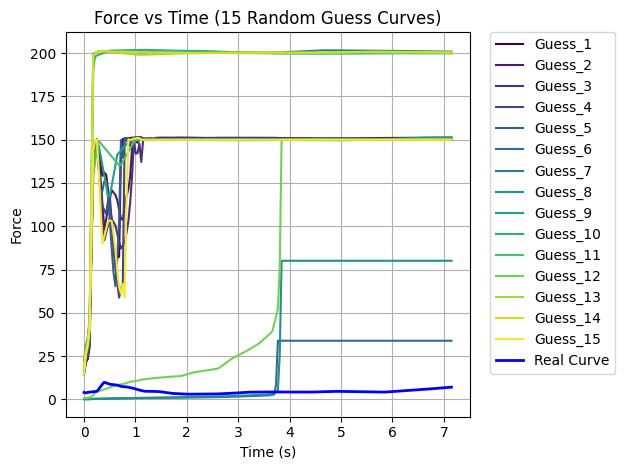

In [6]:
common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)
real_disp_resampled = np.interp(common_time, real_time, real_disp)
num_curves = len(guess_data_all)
colormap = plt.get_cmap('viridis')
for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_disp_resampled, color=color, label=f'Guess_{i}')

plt.plot(common_time, real_disp_resampled, 'b-', label='Real Curve', linewidth=2)

# Finalize plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Force vs Time (15 Random Guess Curves)')
plt.grid(True)
plt.tight_layout()
plt.show()

# GP Model

In [ ]:
file_path = 'H:\\moldflow\\moldflow_automation\\combined_LHS_parameters.csv'
data = pd.read_csv(file_path)
n_values = data['n'].values
tau_star_values = data['tau_star'].values
B_values = data['B'].values
tau_w_values = data['tau_w'].values
m_values = data['m'].values

train_x = torch.tensor([[n_values[i], tau_star_values[i], B_values[i], tau_w_values[i], m_values[i]] for i in valid_xml ], dtype=torch.float64)
train_y = - torch.tensor([[area_data[i]] for i in valid_xml], dtype=torch.float64)
train_yvar = torch.full_like(train_y, 1e-6)



bounds = torch.tensor([
    [0.1, 1.0, 1.0e+14, 0.001, 0.1],
    [1.0, 1000.0, 1.916e+19, 1.0, 1.9]
], dtype= torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=5)

# GP Model 
model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
model.eval()  


acq_func =  LogExpectedImprovement(model, best_f=train_y.max().item())

candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=1000, #Helps to ensure that we find the global optimum instead of finding the local optimum
        raw_samples=5000,  #More samples increases likelihood of finding good starting point.
)

cand = model(input_transform(candidate))
cand_var = torch.diagonal(cand.covariance_matrix, 0)
cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)


In [ ]:
print(candidate)
print(train_y)
print(train_x)
bounds.shape

# Optimization

In [ ]:
guess_data_all_optim = {}
num_iteration = 5
iterations=[]

for i in range(num_iteration):
    outcome_transform = Standardize(m=1)
    input_transform = Normalize(d=5)

    model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    model.eval()  

    acq_func =  LogExpectedImprovement(model, best_f=train_y.max())


    candidate_optim, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=1000, #Helps to ensure that we find the global optimum instead of finding the local optimum
            raw_samples=5000,  #More samples increases likelihood of finding good starting point.
    )

    print(f"Iteration {i+1}: Suggested new parameters (n, tau_star, B, tau_w, m)", candidate_optim)
    iterations.append(candidate_optim)

    study_name = f"optimization_{i+1}"
    Project = Synergy.Project

    # Viscosity Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090,1)
    Prop.FieldDescription(53030, f"{candidate_optim[0,0].item()}, {candidate_optim[0,1].item()}, {candidate_optim[0,2].item()}, 0.004, 2.412, 6.272, 0.305")
    PropEd.CommitChanges("Process Conditions")

    # Wall Slip Parameters

    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(candidate_optim[0,3].item())
    DVec.AddDouble(candidate_optim[0,4].item())
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
        
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"G:\\Oskay Sözen\\viscosity\\optimization_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()

    time.sleep(3)

    Synergy.OpenProject("G:\\Oskay Sözen\\viscosity\\viscosity.mpi")         # PROJECT NAME!!!!!!!!!!!!!!!!
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_{i+1}", "Study")

    # Plot Export

    PlotMgr = Synergy.PlotManager
    time.sleep(3)
    Plot = PlotMgr.FindPlotByName2("Press force:XY Plot", "Press force")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(3)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\optimization_{i + 1}.xml", "Metric")



# Write the output to a log file
    with open(f"H:\\Log_Files\\optimization_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_{i+1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []
    time.sleep(1) 
    count = 0   
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
        if count >= 30:
            break
        
        time_value = time_block.attrib.get('Value')
        dept_value = dept_block.find('DeptValues').text.strip()
        guess_data.append((time_value, dept_value))

        count += 1
    if len(guess_data) < 30:
        print(f"Warning: File {i+1} has incomplete or corrupted data (only {len(guess_data)} entries). Skipping.")
        continue
    guess_data_all_optim[f"guess_data_{i+1}"] = guess_data

    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  
        
    globals()[f"guess_time_{5 + num_iteration}"] = guess_time
    globals()[f"guess_disp_{5 + num_iteration}"] = guess_disp
    
    mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(mean_s_error)
    valid_xml.append(len(area_data) - 1)

    # New Values

    train_x = torch.cat([train_x, candidate_optim], dim=0)
    train_y = torch.cat([train_y, -torch.tensor([[area_data[-1]]])], dim=0)
    train_yvar = torch.full_like(train_y, 1e-6)

    current_best_area = train_y.max().item()

    if abs(current_best_area) < 1e-2:
        print(f"Converged after {i+1} iteration")
        break
    
best_params = train_x[train_y.argmax()]
best_area = train_y.max().item()
print(f"Best parameters (n, tau_star, B, tau_w, m): {best_params}, with MSE : {best_area}")





In [ ]:
num_curves = len(guess_data_all)
colormap = plt.get_cmap('viridis')
for i, (key, guess_data) in enumerate(guess_data_all.items(), start=1):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    
    color = colormap((i - 1) / max(num_curves - 1, 1))
    plt.plot(common_time, guess_disp_resampled, color=color, label=f'Guess_{i}')


real_disp_resampled = np.interp(common_time, real_time, real_disp)
plt.plot(common_time, real_disp_resampled, 'b-', label='Real Curve', linewidth=2)

# Finalize plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Force vs Time (5 Random Guess Curves)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

num_curves = len(guess_data_all_optim)
colormap = plt.get_cmap('viridis', num_curves)  
plt.plot(common_time, real_disp_resampled, 'b-', label='Real Curve')
for i, (key, guess_data) in enumerate(guess_data_all_optim.items()):
    if isinstance(guess_data[0], (list, tuple)) and len(guess_data[0]) == 2:
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]
        guess_disp = guess_data_array[:, 1]

        guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

        color = colormap(i) 
        plt.plot(common_time, guess_disp_resampled, color=color, label=f'Guess_{i+1}')

# Finalize plot
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Force vs Time (Optimized Curves)')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()  
plt.show()